<a href="https://colab.research.google.com/github/nkefeyan-22-26/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Assignment1/Econ%205200%20Assignment1%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Manual Data Construction
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    # ... add 1 more item
    {'Item': 'Groceries', 'Price_2016': 80, 'Price_2024': 100},
    {'Item': 'Utilities', 'Price_2016': 50, 'Price_2024': 75},
    {'Item': 'Netflix', 'Price_2016': 6.99, 'Price_2024': 7.99},
    {'Item': 'Textbooks', 'Price_2016': 45, 'Price_2024': 85}
]

In [27]:
# Define the "Machine" (Function)
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

# Run the Loop
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
Groceries: 25.00% Inflation
Utilities: 50.00% Inflation
Netflix: 14.31% Inflation
Textbooks: 88.89% Inflation


In [28]:
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key='=')

# Fetch Series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA') # Added Rent
# ... fetch remaining series
food_away = fred.get_series('CUSR0000SEFV') # chipotle proxy
streaming = fred.get_series('CUSR0000SERA02') # netflix proxy

In [29]:
import pandas as pd
df = pd.DataFrame({'CPI': official_cpi,
                  'Tuition': tuition,
                  'Rent': rent,
                  'Chipotle bowl': food_away,
                  'Netflix': streaming})

In [30]:
df

,CPI,Tuition,Rent,Chipotle bowl,Netflix
1947-01-01,21.480,NaN,NaN,NaN,NaN
1947-02-01,21.620,NaN,NaN,NaN,NaN
1947-03-01,22.000,NaN,NaN,NaN,NaN
1947-04-01,22.000,NaN,NaN,NaN,NaN
1947-05-01,21.950,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-08-01,323.364,895.305,437.462,384.909,592.604
2025-09-01,324.368,897.302,438.322,385.451,593.928
2025-10-01,NaN,NaN,NaN,NaN,NaN
2025-11-01,325.031,902.001,438.875,387.202,599.226


In [31]:
start_date = "1947-01-01"
df = df.dropna()
df_filtered = df[df.index >= start_date]
df_rebased = (df_filtered / df_filtered.iloc[0]) * 100

In [32]:
import matplotlib.pyplot as plt

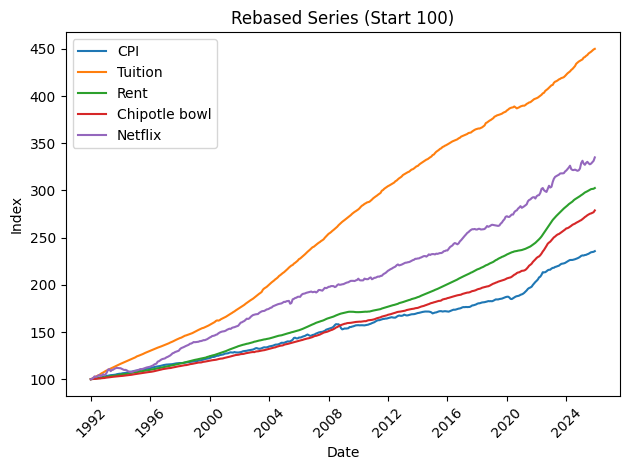

In [33]:
data_to_plot = df_rebased

plt.figure()
for col in data_to_plot.columns:
    plt.plot(data_to_plot.index, data_to_plot[col], label=col)

plt.title("Rebased Series (Start 100)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

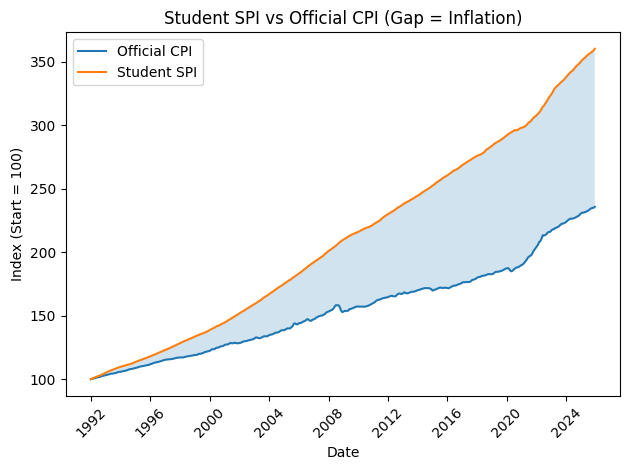

In [34]:
data = df_rebased.copy()

weights = {
    "Tuition": 0.40,
    "Rent": 0.30,
    "Chipotle bowl": 0.20,
    "Netflix": 0.10
}

data["Student_SPI"] = 0
for col in weights:
    data["Student_SPI"] = data["Student_SPI"] + data[col] * weights[col]

plot_df = data[["CPI", "Student_SPI"]].dropna()

plt.figure()
plt.plot(plot_df.index, plot_df["CPI"], label="Official CPI")
plt.plot(plot_df.index, plot_df["Student_SPI"], label="Student SPI")

# use of plt.fill_between
plt.fill_between(
    plot_df.index,
    plot_df["Student_SPI"],
    plot_df["CPI"],
    alpha=0.2
)

plt.title("Student SPI vs Official CPI (Gap = Inflation)")
plt.xlabel("Date")
plt.ylabel("Index (Start = 100)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

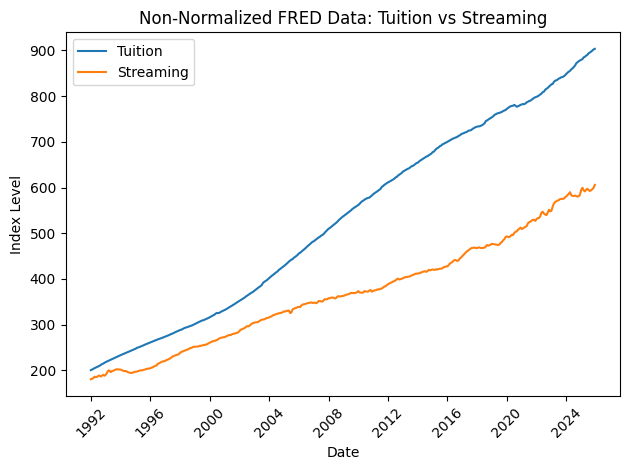

In [35]:
cpi_tuition = df["Tuition"] # tuition
cpi_streaming = df["Netflix"] # streaming

# drop rows with missing values again
plot_df = pd.concat([cpi_tuition, cpi_streaming], axis=1).dropna()
plot_df.columns = ["Tuition (raw)", "Streaming (raw)"]

plt.figure()
plt.plot(plot_df.index, plot_df["Tuition (raw)"], label="Tuition")
plt.plot(plot_df.index, plot_df["Streaming (raw)"], label="Streaming")

plt.title("Non-Normalized FRED Data: Tuition vs Streaming")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Why this is a "Data Crime": As expected, tuition looks huge, and streaming looks tiny. We must first observe the units in which both are being calculated. Index values are not the actual numbers, they are scaled to a base period, and since in this case we have different base years, it makes the large-number series (tuition) look huge and the small-number series (streaming) look tiny. This can lead to false conclusions about how intense inflation was.

---



Original df info:
  Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
  Index sample: DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01'], dtype='datetime64[ns]', freq=None)
  Date range: 1992-01-01 00:00:00 to 2025-12-01 00:00:00
  Columns: ['CPI', 'Tuition', 'Rent', 'Chipotle bowl', 'Netflix']

Boston CPI data info:
  Date range: 1914-12-01 00:00:00 to 2025-11-01 00:00:00
  Total observations: 1332

Overlapping date range: 1992-01-01 00:00:00 to 2025-11-01 00:00:00

✓ Merge successful! Boston_CPI added.
  Non-null values: 204 / 407
  Filled 203 missing values using forward-fill

Plotting:
  National CPI: CPI
  Boston CPI: Boston_CPI
  Student costs: Tuition

Available columns: ['CPI', 'Tuition', 'Rent', 'Chipotle bowl', 'Netflix', 'Boston_CPI']



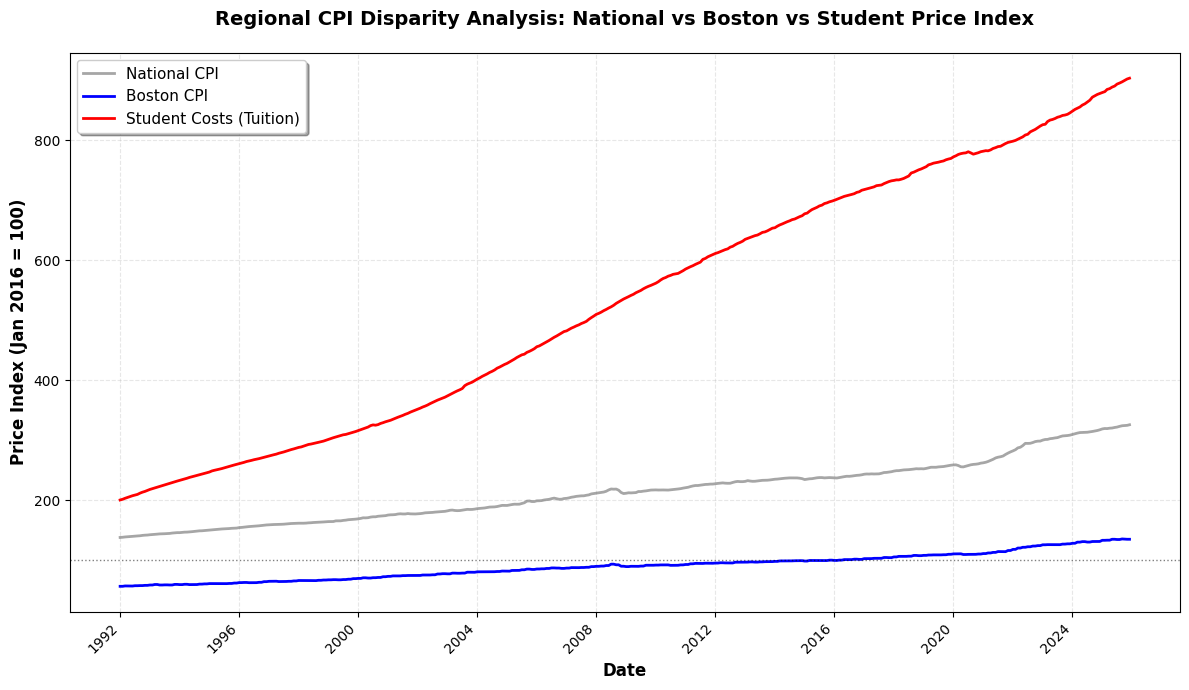


=== REGIONAL DISPARITY ANALYSIS ===

Latest Values (most recent date):
  National CPI: 326.03
  Boston CPI:   135.25
  Student Costs: 903.40

Cumulative Change from Jan 2016 baseline:
  National CPI: +226.03%
  Boston CPI:   +35.25%
  Student Costs: +803.40%

Regional Disparity (Boston vs National):
  Boston is 190.78 points lower than national average

Student Burden (Student vs Boston):
  Student costs are 768.15 points higher than Boston CPI


In [36]:
# Fetch Boston CPI data
# CUURA103SA0: Consumer Price Index for All Urban Consumers:
# All Items in Boston-Cambridge-Newton, MA-NH (CBSA)
boston_cpi_raw = fred.get_series('CUURA103SA0')

# Convert to DataFrame
boston_df = pd.DataFrame({
    'Date': boston_cpi_raw.index,
    'Boston_CPI_Raw': boston_cpi_raw.values
})
boston_df.set_index('Date', inplace=True)

# Re-index to Jan 1, 2016 = 100
baseline_date = pd.Timestamp('2016-01-01')

# Handle case where exact date might not exist (use nearest)
if baseline_date not in boston_df.index:
    # Find the closest date to Jan 1, 2016
    idx = boston_df.index.get_indexer([baseline_date], method='nearest')[0]
    baseline_value = boston_df.iloc[idx]['Boston_CPI_Raw']
    print(f"Using nearest date to 2016-01-01: {boston_df.index[idx]}")
else:
    baseline_value = boston_df.loc[baseline_date, 'Boston_CPI_Raw']

# Reindex Boston CPI to 100 at baseline
boston_df['Boston_CPI'] = (boston_df['Boston_CPI_Raw'] / baseline_value) * 100

# ===== DIAGNOSTIC & FIX SECTION =====
# Check your df structure first
print("Original df info:")
print(f"  Index type: {type(df.index)}")
print(f"  Index sample: {df.index[:3]}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Columns: {df.columns.tolist()}\n")

# Ensure df has a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    print("Converting df index to DatetimeIndex...")
    df.index = pd.to_datetime(df.index)

print("Boston CPI data info:")
print(f"  Date range: {boston_df.index.min()} to {boston_df.index.max()}")
print(f"  Total observations: {len(boston_df)}\n")

# Check for date overlap
overlap_start = max(df.index.min(), boston_df.index.min())
overlap_end = min(df.index.max(), boston_df.index.max())
print(f"Overlapping date range: {overlap_start} to {overlap_end}\n")

# Merge the Boston CPI data with your existing dataframe
df_merged = df.merge(boston_df[['Boston_CPI']],
                     left_index=True,
                     right_index=True,
                     how='left')

# Check if merge was successful
if 'Boston_CPI' in df_merged.columns:
    print(f"✓ Merge successful! Boston_CPI added.")
    print(f"  Non-null values: {df_merged['Boston_CPI'].notna().sum()} / {len(df_merged)}")
    df = df_merged
else:
    print("✗ Merge failed! Boston_CPI column not found.")
    print("This usually means no matching dates between your df and Boston data.")

# Handle missing values by forward filling (common for monthly/bimonthly data)
if 'Boston_CPI' in df.columns:
    missing_before = df['Boston_CPI'].isna().sum()
    df['Boston_CPI'] = df['Boston_CPI'].ffill()  # Modern pandas syntax
    missing_after = df['Boston_CPI'].isna().sum()
    if missing_before > 0:
        print(f"  Filled {missing_before - missing_after} missing values using forward-fill")

    # If still missing values at the start, backfill
    if df['Boston_CPI'].isna().any():
        df['Boston_CPI'] = df['Boston_CPI'].bfill()  # Modern pandas syntax
        print(f"  Backfilled remaining missing values at start of series")
else:
    raise KeyError("Boston_CPI column could not be created. Check date alignment between your df and FRED data.")

# Alternative: interpolate for smoother transitions
# df['Boston_CPI'].interpolate(method='linear', inplace=True)

# ===== COLUMN MAPPING =====
# Map your actual column names to the analysis
# Adjust these based on what you want to analyze:
national_cpi_col = 'CPI'  # Your national CPI column
student_spi_col = 'Tuition'  # Change this to whichever represents student costs
boston_cpi_col = 'Boston_CPI'  # The newly fetched Boston data

print(f"\nPlotting:")
print(f"  National CPI: {national_cpi_col}")
print(f"  Boston CPI: {boston_cpi_col}")
print(f"  Student costs: {student_spi_col}")
print(f"\nAvailable columns: {df.columns.tolist()}\n")

# Create the comparison plot
plt.figure(figsize=(12, 7))

# Plot all three lines
plt.plot(df.index, df[national_cpi_col],
         color='grey', linewidth=2, label='National CPI', alpha=0.7)
plt.plot(df.index, df[boston_cpi_col],
         color='blue', linewidth=2, label='Boston CPI')
plt.plot(df.index, df[student_spi_col],
         color='red', linewidth=2, label='Student Costs (Tuition)')

# Formatting
plt.title('Regional CPI Disparity Analysis: National vs Boston vs Student Price Index',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price Index (Jan 2016 = 100)', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--')

# Add horizontal reference line at 100
plt.axhline(y=100, color='black', linestyle=':', alpha=0.5, linewidth=1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Tight layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print summary statistics for analysis
print("\n=== REGIONAL DISPARITY ANALYSIS ===\n")
print("Latest Values (most recent date):")
print(f"  National CPI: {df[national_cpi_col].iloc[-1]:.2f}")
print(f"  Boston CPI:   {df[boston_cpi_col].iloc[-1]:.2f}")
print(f"  Student Costs: {df[student_spi_col].iloc[-1]:.2f}")

print("\nCumulative Change from Jan 2016 baseline:")
print(f"  National CPI: +{df[national_cpi_col].iloc[-1] - 100:.2f}%")
print(f"  Boston CPI:   +{df[boston_cpi_col].iloc[-1] - 100:.2f}%")
print(f"  Student Costs: +{df[student_spi_col].iloc[-1] - 100:.2f}%")

print("\nRegional Disparity (Boston vs National):")
disparity = df[boston_cpi_col].iloc[-1] - df[national_cpi_col].iloc[-1]
print(f"  Boston is {abs(disparity):.2f} points {'higher' if disparity > 0 else 'lower'} than national average")

print("\nStudent Burden (Student vs Boston):")
student_burden = df[student_spi_col].iloc[-1] - df[boston_cpi_col].iloc[-1]
print(f"  Student costs are {abs(student_burden):.2f} points {'higher' if student_burden > 0 else 'lower'} than Boston CPI")